$
\def\D{\mathcal{D}}
\def\ipar{m}
\def\R{\mathbb{R}}
\def\del{\partial}
\def\vec{\bf}
\def\priorm{\mu_0}
\def\C{\mathcal{C}}
\def\Acal{\mathcal{A}}
\def\postm{\mu_{\rm{post}}}
\def\iparpost{\ipar_\text{post}}
\def\obs{\vec{d}} 
\def\yobs{\obs^{\text{obs}}}
\def\obsop{\mathcal{B}}
\def\dd{\vec{\bar{d}}}
\def\iFF{\mathcal{F}}
\def\iFFadj{\mathcal{F}^*}
\def\ncov{\Gamma_{\mathrm{noise}}}
$
# Example: Bayesian initial condition inversion in an advection-diffusion problem 

In this example we tackle the problem of quantifying the uncertainty in the solution of an inverse problem governed by a parabolic PDE via the Bayesian inference framework. The underlying PDE is a time-dependent advection-diffusion equation in which we seek to infer an unknown initial condition from spatio-temporal point measurements.

### The Bayesian inverse problem:

Following the Bayesian framework, we utilize 
a Gaussian prior measure $\priorm = \mathcal{N}(\ipar_0,\C_0)$,
with $\C_0=\Acal^{-2}$ where $\Acal$ is an elliptic differential operator as 
described in the PoissonBayesian example, and use an additive
Gaussian noise model. Therefore, the solution of the Bayesian inverse
problem is the posterior measure, $\postm = \mathcal{N}(\iparpost,\C_\text{post})$ with
$\iparpost$ and $\C_\text{post}$.

- The posterior mean $\iparpost$ is characterized as the minimizer of

$$
\begin{aligned}
& \mathcal{J}(\ipar) :=
  \frac{1}{2} \left\| \mathcal{B}u(\ipar) -\obs  \right\|^2_{\ncov^{-1}}
  + \frac 12 \left\| \Acal(\ipar - \ipar_0 \right)\|^2_{L^2(\D)},
\end{aligned}
$$

which can also be interpreted as the regularized functional to be
minimized in deterministic inversion. The observation operator $\mathcal{B}$ extracts the values of the forward solution $u$ on a set of
locations $\{\vec{x}_1, \ldots, \vec{x}_n\} \subset \D$ at
times $\{t_1, \ldots, t_N\} \subset [0, T]$.

- The posterior covariance $\C_{\text{post}}$ is the inverse of the Hessian of $\mathcal{J}(\ipar)$, i.e.,

$$
\C_{\text{post}} = (\iFFadj \ncov^{-1} \iFF + \C_0^{-1})^{-1}.
$$


### The forward problem:

The PDE in the parameter-to-observable map $\iFF$ models diffusive transport
in a domain $\D \subset \R^d$ ($d \in \{2, 3\}$):

$$
\begin{split}
u_t - \kappa\Delta u + \bf{v} \cdot \nabla u &= 0     & \quad \text{in } \D\times(0,T),\\
                                 u(\cdot, 0) &= \ipar & \quad \text{in } \D,\\
                \kappa \nabla u\cdot \vec{n} &= 0     & \quad \text{on } \partial\D \times (0,T).
\end{split}
$$

Here, $\kappa > 0$ is the diffusion coefficient and $T > 0$ is the final
time. The velocity field
$\vec{v}$ is computed by solving the following steady-state
Navier-Stokes equation with the side walls driving the flow:

$$
\begin{aligned}
- \frac{1}{\operatorname{Re}} \Delta \bf{v} + \nabla q + \bf{v} \cdot \nabla \bf{v} &= 0 &\quad&\text{ in }\D,\\
\nabla \cdot \bf{v} &= 0 &&\text{ in }\D,\\
\bf{v} &= \bf{g} &&\text{ on } \partial\D.
\end{aligned}
$$

Here, $q$ is pressure, $\text{Re}$ is the Reynolds number. The Dirichlet boundary data
$\vec{g} \in \R^d$ is given by 
$\vec{g} = \vec{e}_2$ on the left wall of the domain, 
$\vec{g}=-\vec{e}_2$ on the right wall,  and $\vec{g} = \vec{0}$ everywhere else.

### The adjoint problem:

$$
\begin{aligned}
-p_t - \nabla \cdot (p \vec{v}) - \kappa \Delta p  &= -\obsop^* (\obsop u - \obs) & \quad &\text{ in } \D\times (0,T),\\
                                      p(\cdot, T) &= 0             &       &\text{ in } \D,\\ 
(\vec{v}p+\kappa\nabla p)\cdot \vec{n}            &= 0             &       &\text{ on } \partial\D\times (0,T).
\end{aligned}
$$

## 1. Load modules

In [1]:
from __future__ import absolute_import, division, print_function
import dolfin as dl
import math
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import sys

sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "../") )
sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "..") + "/applications/ad_diff/" )
sys.path.append( "../" )
from hippylib import *

sys.path.append( "../applications/ad_diff/" )
from model_ad_diff import TimeDependentAD

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)
np.random.seed(1)

## 2. Construct the velocity field

In [2]:
def v_boundary(x,on_boundary):
    return on_boundary

def q_boundary(x,on_boundary):
    return x[0] < dl.DOLFIN_EPS and x[1] < dl.DOLFIN_EPS
        
def computeVelocityField(mesh):
    Xh = dl.VectorFunctionSpace(mesh,'Lagrange', 2)
    Wh = dl.FunctionSpace(mesh, 'Lagrange', 1)
    if dlversion() <= (1,6,0):
        XW = dl.MixedFunctionSpace([Xh, Wh])
    else:
        mixed_element = dl.MixedElement([Xh.ufl_element(), Wh.ufl_element()])
        XW = dl.FunctionSpace(mesh, mixed_element)

    Re = 1e2
    # set boundary conditions
    g = dl.Expression(('0.0','(x[0] < 1e-14) - (x[0] > 1 - 1e-14)'), degree=1)
    bc1 = dl.DirichletBC(XW.sub(0), g, v_boundary)
    
    bc2 = dl.DirichletBC(XW.sub(1), dl.Constant(0), q_boundary, 'pointwise')
    
    bcs = [bc1, bc2]
    
    vq = dl.Function(XW)
    (v,q) = dl.split(vq)
    (v_test, q_test) = dl.TestFunctions (XW)
    
    def strain(v):
        return dl.sym(dl.nabla_grad(v))
    
    F = ( (2./Re)*dl.inner(strain(v),strain(v_test))+ dl.inner (dl.nabla_grad(v)*v, v_test)
           - (q * dl.div(v_test)) + ( dl.div(v) * q_test) ) * dl.dx
           
    dl.solve(F == 0, vq, bcs, solver_parameters={"newton_solver":
                                         {"relative_tolerance":1e-4, "maximum_iterations":100}})
    
    plt.figure(figsize=(15,5))
    vh = dl.project(v,Xh)
    qh = dl.project(q,Wh)
    nb.plot(nb.coarsen_v(vh), subplot_loc=121,mytitle="Velocity")
    nb.plot(qh, subplot_loc=122,mytitle="Pressure")
    plt.show()
        
    return v

## 3. Set up the mesh and finite element spaces

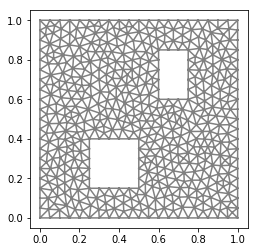

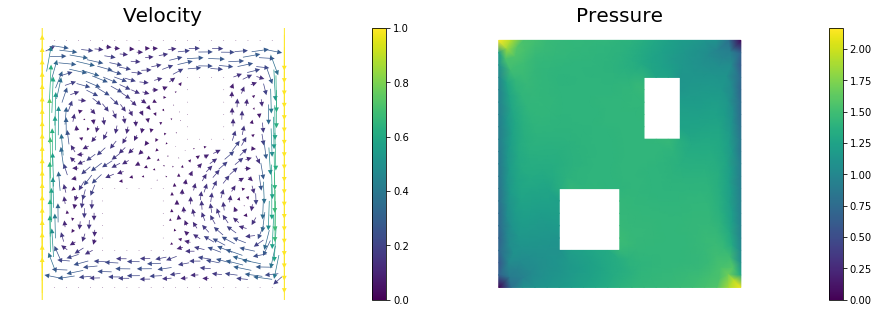

Number of dofs: 2023
done with initialization on identity vectors


In [3]:
mesh = dl.Mesh("ad_20.xml") # dl.refine( )
dl.plot(mesh)
wind_velocity = computeVelocityField(mesh)
Vh = dl.FunctionSpace(mesh, "Lagrange", 2)
print("Number of dofs: {0}".format( Vh.dim() ) )

u = dl.TrialFunction(Vh)
v = dl.TestFunction(Vh)

a = dl.inner(u,v)*dl.dx
Identity = dl.assemble(a)
priorR   = dl.assemble(a)
identity_vectors = [dl.Function(Vh) for i in range(Identity.array().shape[0])]
priorR_vectors = [dl.Function(Vh) for i in range(priorR.array().shape[0])]
[identity_vectors[i].vector().set_local(Identity.array()[i]) for i in range(Identity.array().shape[0])]
[  priorR_vectors[i].vector().set_local(priorR.array()[i])   for i in range(priorR.array().shape[0])]
print('done with initialization on identity vectors')


## 4. Set up model (prior, true/proposed initial condition)

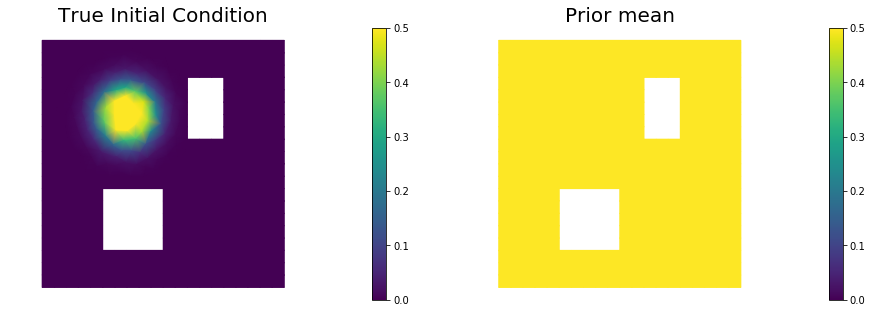

In [4]:
gamma = 1
delta = 8
prior = BiLaplacianPrior(Vh, gamma, delta)

prior.mean = dl.interpolate(dl.Constant(0.5), Vh).vector()
true_initial_condition = dl.interpolate(dl.Expression('min(0.5,exp(-100*(pow(x[0]-0.35,2) +  pow(x[1]-0.7,2))))', degree=5), Vh).vector()
problem = TimeDependentAD(mesh, [Vh,Vh,Vh], 0., 4., 1., .2, wind_velocity, True, prior)

objs = [dl.Function(Vh,true_initial_condition),
        dl.Function(Vh,prior.mean)]

mytitles = ["True Initial Condition", "Prior mean"]
nb.multi1_plot(objs, mytitles)
plt.show()

# nb.plot_pts(targets, misfit.d, mytitle="Observation", subplot_loc=122)


## 5. Generate the synthetic observations

In [5]:
rel_noise = 0.1
utrue = problem.generate_vector(STATE)
x = [utrue, true_initial_condition, None]    

ntargets = 80
ndim = 2
rel_noise = 0.1
n_targets_created = 0
targets = []

while n_targets_created < ntargets:
    target = np.random.uniform(0.05, 0.95, ndim)
    box1 = 0.2 < target[0] < 0.6 and 0.15 < target[1] < 0.5
    box2 = 0.55 < target[0] < 0.85 and 0.55 < target[1] < 0.9
    
    if not box1 and not box2:
        n_targets_created += 1
        targets.append(target)
targets = np.array(targets)
misfit = PointwiseStateObservation(Vh, targets)
MAX = misfit.d.norm("linf")
noise_std_dev = rel_noise * MAX
misfit.noise_variance = noise_std_dev*noise_std_dev 
misfitds = []

misfit d shape: 80


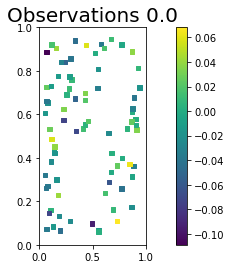

misfit d shape: 80


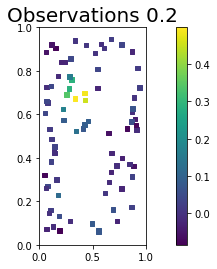

misfit d shape: 80


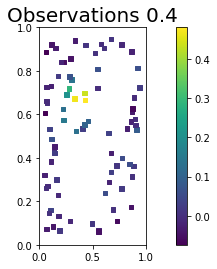

misfit d shape: 80


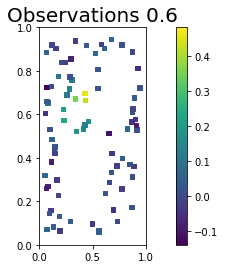

misfit d shape: 80


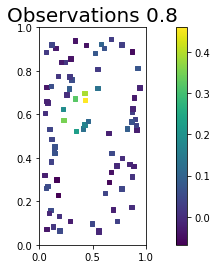

misfit d shape: 80


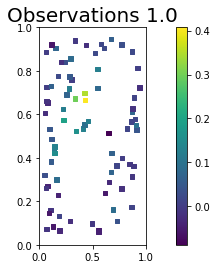

misfit d shape: 80


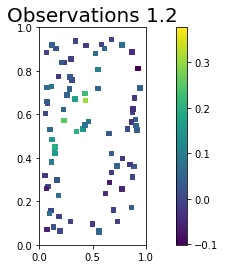

misfit d shape: 80


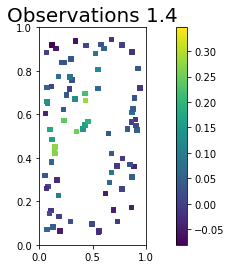

misfit d shape: 80


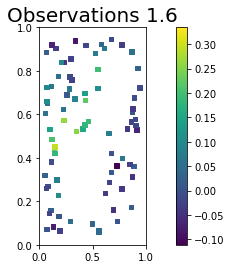

misfit d shape: 80


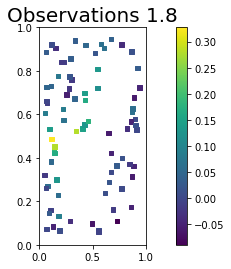

misfit d shape: 80


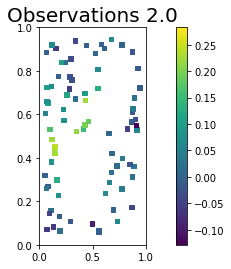

misfit d shape: 80


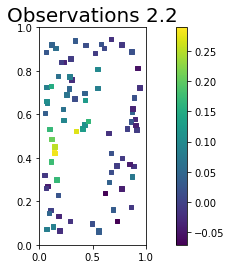

misfit d shape: 80


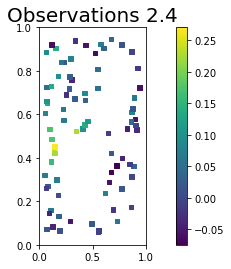

misfit d shape: 80


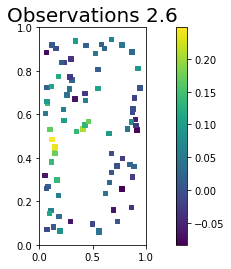

misfit d shape: 80


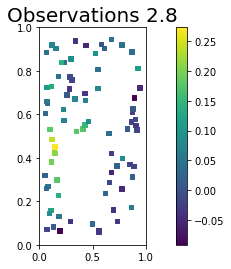

misfit d shape: 80


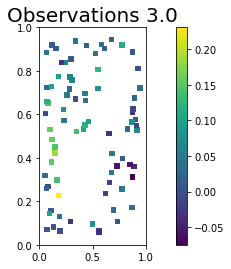

misfit d shape: 80


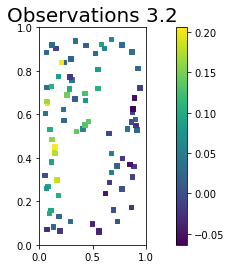

misfit d shape: 80


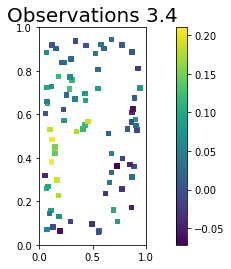

misfit d shape: 80


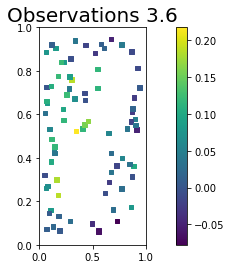

misfit d shape: 80


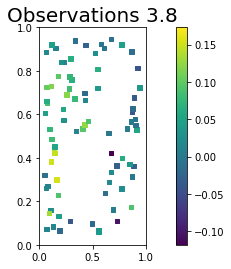

misfit d shape: 80


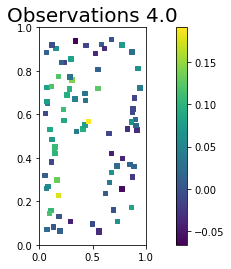

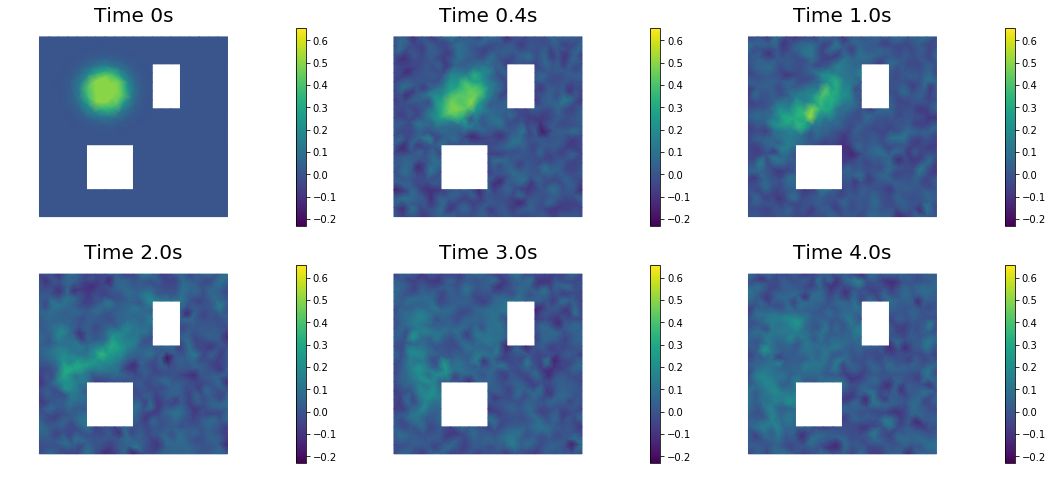

In [6]:
# Only care about this case of utrue:
for i in range(len(utrue.times)):
    problem.solveFwd(x[STATE], x, 1e-9, process_noise_std_dev=0.01)
    MAX = utrue.norm("linf","linf")
    noise_std_dev = rel_noise * MAX    
    problem.ud.copy(utrue)
    parRandom.normal_perturb(noise_std_dev, problem.ud)
    problem.noise_variance = noise_std_dev*noise_std_dev
    misfit.B.mult(problem.ud.data[i], misfit.d)
    misfitds.append(misfit.d)
    print("misfit d shape: " + str(len(misfit.d)))
    vmax = max( max(utrue.data[i]), misfit.d.max() )
    vmin = min( min(utrue.data[i]), misfit.d.min() )    
    nb.plot_pts(targets, misfit.d, mytitle="Observations " + str(utrue.times[i]), subplot_loc=122, vmin=vmin, vmax=vmax)    
    plt.show()
nb.show_solution(Vh, true_initial_condition, problem.ud, "Solution")



## 6. Test the gradient and the Hessian of the cost (negative log posterior)

(yy, H xx) - (xx, H yy) =  1.844525792476016e-14


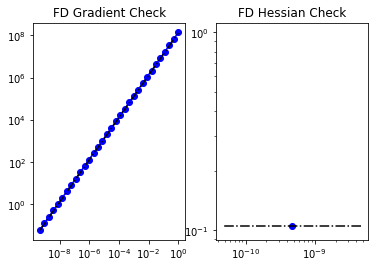

In [7]:
a0 = true_initial_condition.copy()
_ = modelVerify(problem, a0, 1e-12, is_quadratic=True)

## 7. Evaluate the gradient

In [8]:
[u,a,p] = problem.generate_vector()
problem.solveFwd(u, [u,a,p], 1e-12)
problem.solveAdj(p, [u,a,p], 1e-12)
mg = problem.generate_vector(PARAMETER)
grad_norm = problem.evalGradientParameter([u,a,p], mg)
        
print("(g,g) = ", grad_norm)

(g,g) =  24702.812715940345


## 8. The Gaussian approximation of the posterior

Single Pass Algorithm. Requested eigenvectors: 80; Oversampling 20.


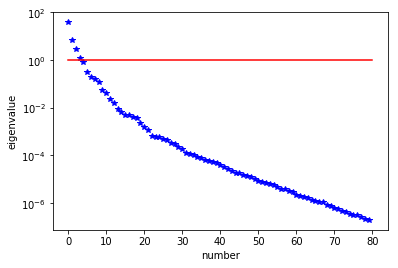

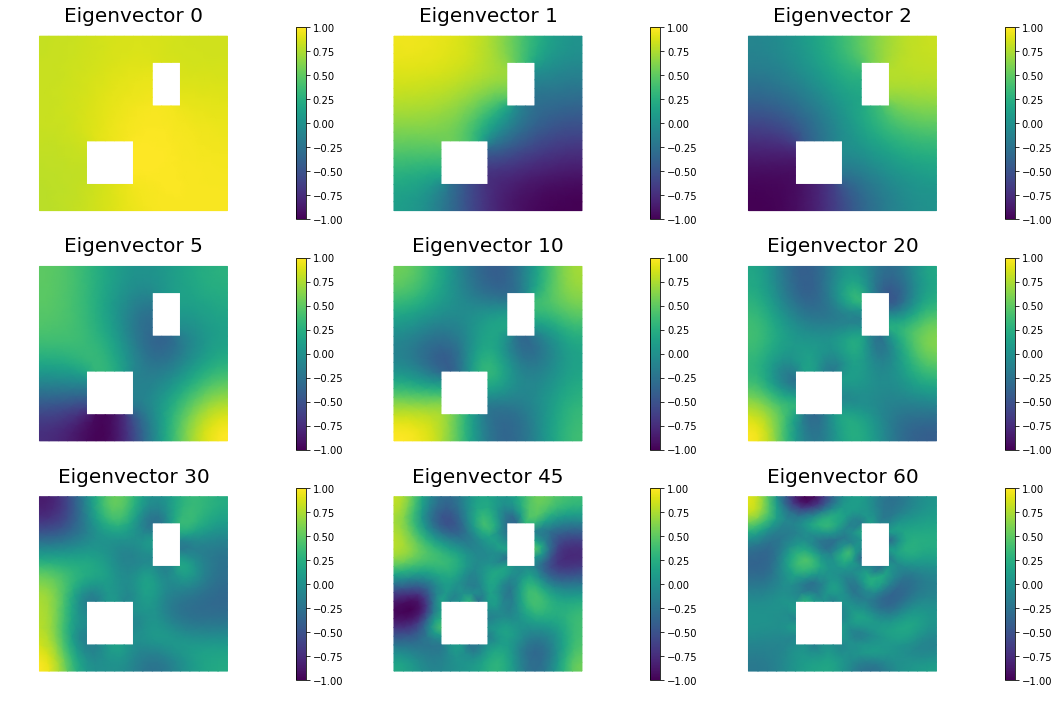

In [9]:
H = ReducedHessian(problem, 1e-12, misfit_only=True) 

k = 80
p = 20
print( "Single Pass Algorithm. Requested eigenvectors: {0}; Oversampling {1}.".format(k,p) )
Omega = MultiVector(x[PARAMETER], k+p)
parRandom.normal(1., Omega)
lmbda, V = singlePassG(H, prior.R, prior.Rsolver, Omega, k)


posterior = GaussianLRPosterior( prior, lmbda, V )

# prior = posterior

plt.plot(range(0,k), lmbda, 'b*', range(0,k+1), np.ones(k+1), '-r')
plt.yscale('log')
plt.xlabel('number')
plt.ylabel('eigenvalue')

nb.plot_eigenvectors(Vh, V, mytitle="Eigenvector", which=[0,1,2,5,10,20,30,45,60])


Construct covariance and mean ...hahaha
Form K and others

In [12]:
np_priorR = np.zeros((len(identity_vectors), len(identity_vectors)))
#R = C^{-1}
aa = dl.Function(Vh)
aa.vector().set_local(true_initial_condition.get_local())
Ra = dl.Function(Vh)
Ra.vector().set_local(true_initial_condition.get_local())
aa_holder = dl.Function(Vh)
aa_holder.vector().set_local(true_initial_condition.get_local())
rinv_aa = dl.Function(Vh).vector()
# prior.Rsolver.solve(rinv_aa, aa.vector())
for i in range(len(identity_vectors)):
    #prior.R.mult(identity ) (either canonical vbasis vectors or the below "mass matrix fea" identity)
    prior.R.mult(identity_vectors[i].vector(),priorR_vectors[i].vector())
print(priorR_vectors[1].vector().get_local())
print(identity_vectors[1].vector().get_local())

#for loop, zero out each vector
#vec[i].zero()

# for loop again:
# for ith vector, set_local (getlocal, modified with 1 for the ith degree)
for i in range(len(identity_vectors)):
    np_priorR[:,i] = priorR_vectors[i].vector().get_local()
prior.R.mult(aa.vector(), Ra.vector())
np_priorR_inv = np.linalg.inv(np_priorR)
R2a = np_priorR.dot(aa.vector())
inv_aa = np_priorR_inv.dot(R2a)
dif = R2a - Ra.vector()
nrm = 0
for i in dif:
    nrm += i*i
print(min(dif))
print(max(dif))
print("nrm is " + str(nrm))

# dif = aa_holder.vector() - aa.vector()
# print(min(dif))
# print(max(dif))
# prior.R.mult(aa.vector(), Ra.vector())
# prior.R.mult(aa.vector(),priorR_vectors[i].vector())
# print(aa.vector().get_local().shape)
# priorRnumpy = np.array([priorR_vectors[i].vector().get_local() for i in range(len(priorR_vectors)) ] )
# print("~~~~~~~~~~")
# print(priorRnumpy.shape)
# print(min(rinv_aa.get_local()))
# print(max(rinv_aa.get_local()))
# rinv_aa_np = priorRnumpy @ aa.vector().get_local() #R aa = C^{-1} aa
# print(max(rinv_aa_np))
# print(min(rinv_aa_np))
# #once youve compared priorR Numpy and priorR fenics results
# #THen you manually invert priorR => priorC
# #compare 
# print("~~~~~~~~~~~~~~~~~~~")
# print(min(rinv_aa_np))
# print(max(rinv_aa_np))

[-18999.89667174  16555.09646514   5407.63238173 ...,      0.              0.
      0.        ]
[ 0.  1.  0. ...,  0.  0.  0.]
-6.62357848569e-08
4.76109320857e-08
nrm is 2.72076786169e-13


In [10]:
def np_Vec_to_la_Vec(np_vec):
    holder = dl.Function(Vh)
    holder.vector().set_local(np_vec)
    return holder.vector()

In [11]:
for i in range(len(identity_vectors)):
    identity_vectors[i].vector().zero()
    identity_vectors[i].vector()[i] = 1
    identity_vectors[i].vector().set_local(identity_vectors[i].vector().get_local())

curMean = prior.mean.get_local()
Bops = misfit.B.array()
np_priorR = np.zeros((len(identity_vectors), len(identity_vectors)))
#generate some function
#solve Rsolver * function , look at numpy array of result
#also priorC * function, look at result and compare to above

#they should be identical
for i in range(len(identity_vectors)):
    prior.R.mult(identity_vectors[i].vector(),priorR_vectors[i].vector())
    np_priorR[:,i] = priorR_vectors[i].vector()
Q = np.linalg.inv(np_priorR)
# for i in range(len(identity_vectors)):
#     Q[:,i] = priorC_vectors[i].vector()
Bop = misfit.B.array()

# eigVal, eigVec = np.linalg.eig(Q)
# for i in range(k2):
#     eigVecQ[i].set_local(eigVec[:,i])


<class 'dolfin.cpp.la.GenericVector'>
[[ 0.0493996   0.0496152   0.04880119 ...,  0.00751544  0.00751291
   0.00751206]
 [ 0.0496152   0.04999146  0.0489058  ...,  0.0075115   0.00750893
   0.00750815]
 [ 0.04880119  0.0489058   0.04843739 ...,  0.00752734  0.0075249
   0.00752385]
 ..., 
 [ 0.00751544  0.0075115   0.00752734 ...,  0.05106137  0.05117332
   0.05116026]
 [ 0.00751291  0.00750893  0.0075249  ...,  0.05117332  0.05133118
   0.05125742]
 [ 0.00751206  0.00750815  0.00752385 ...,  0.05116026  0.05125742
   0.05130446]]


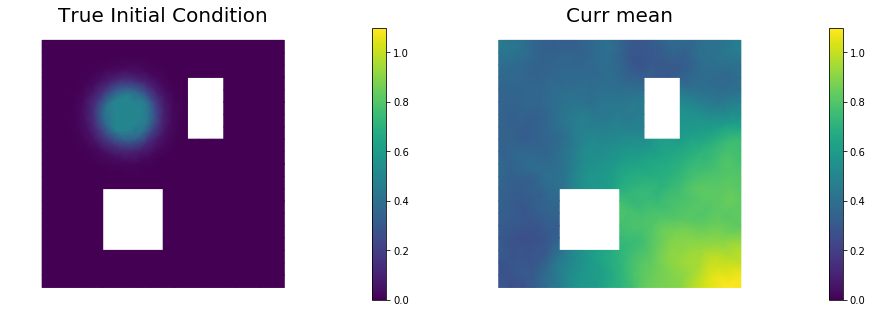

In [12]:
print(type(prior.mean))
print(Q)
c = np.random.multivariate_normal(prior.mean, Q)

objs2 = [dl.Function(Vh, true_initial_condition), dl.Function(Vh, np_Vec_to_la_Vec(c))]
my_titles2 = ["True Initial Condition", "Curr mean"]
nb.multi1_plot(objs2, my_titles2)
plt.show()

In [15]:
Qcopy = np.copy(Q)
iters = 50
k2 = Vh.dim()
eigVecQ = MultiVector(x[PARAMETER], k2)
allEig = np.zeros((iters, k))

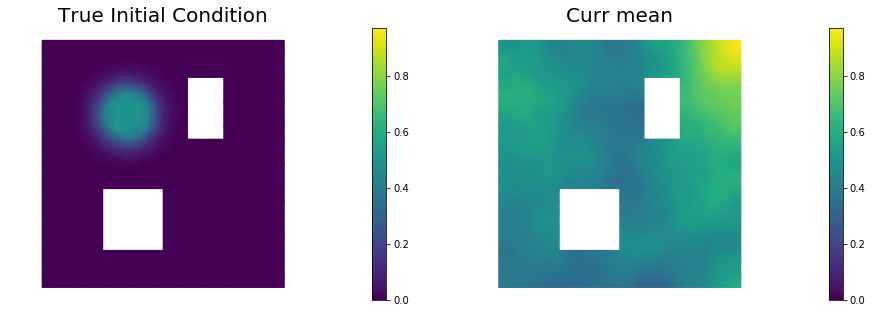

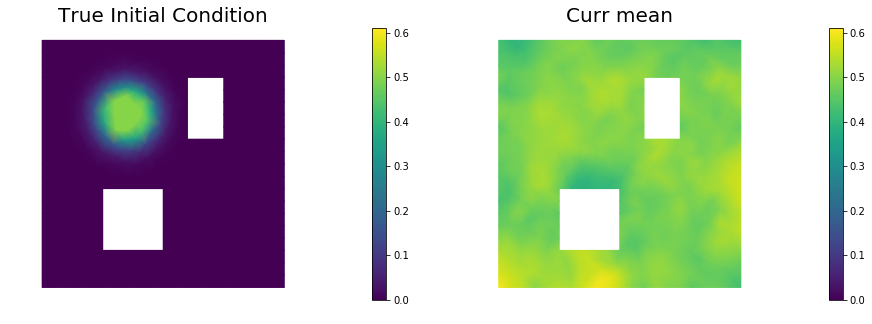

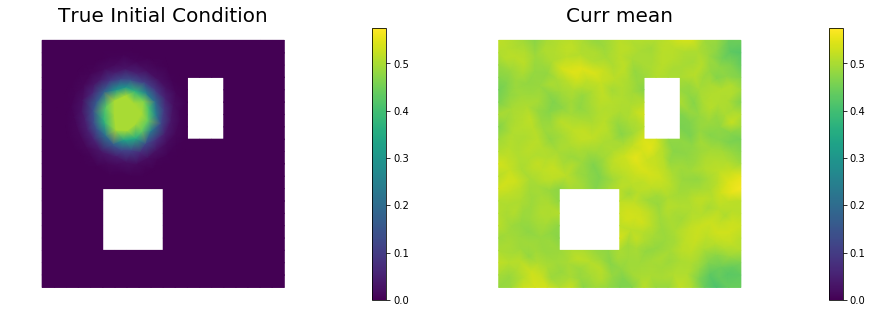

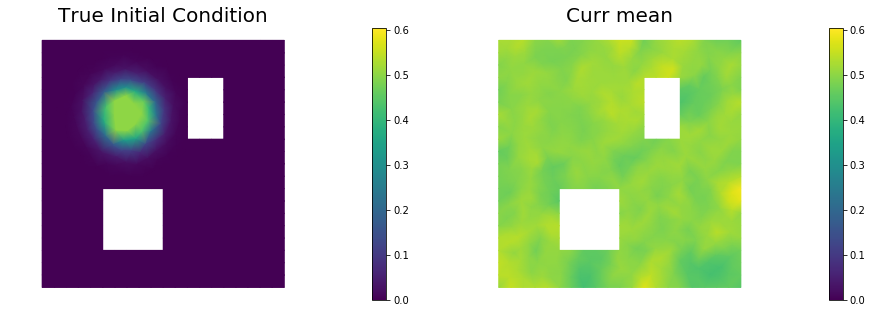

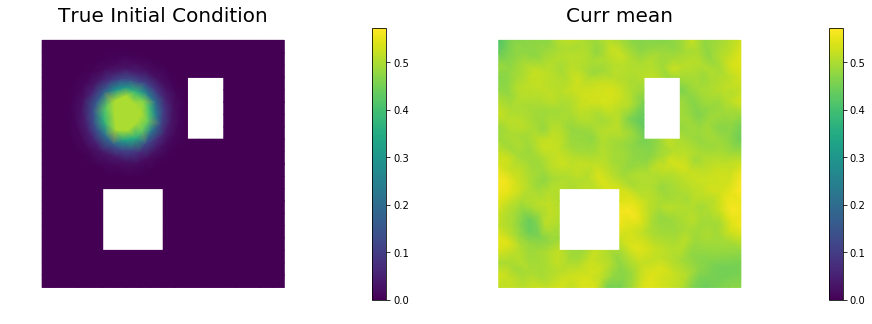

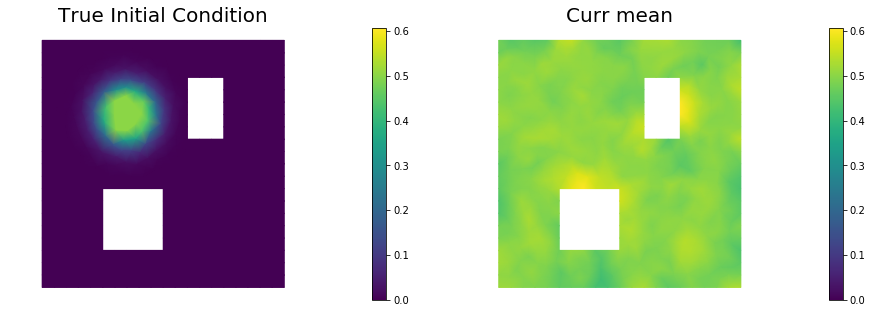

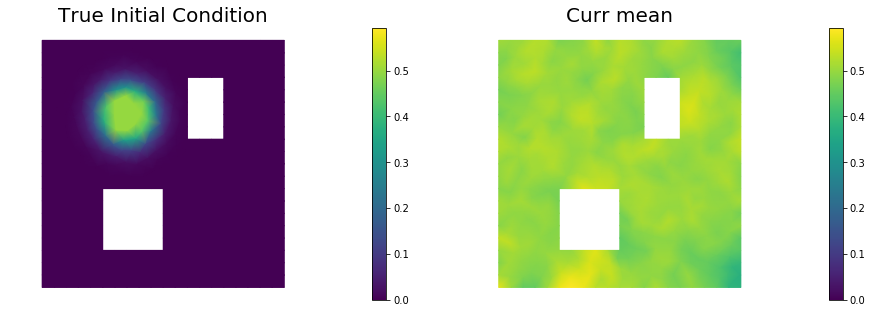

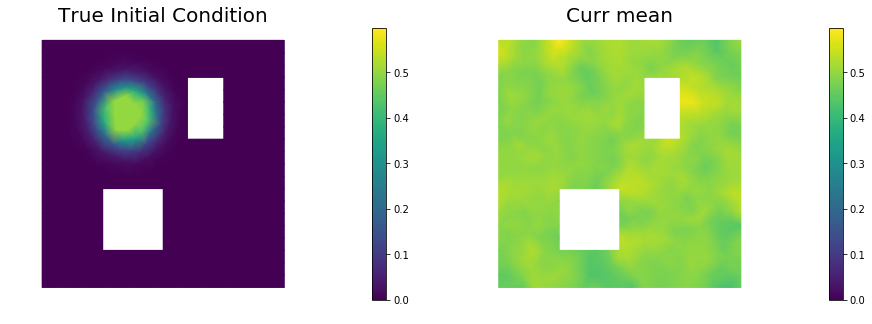

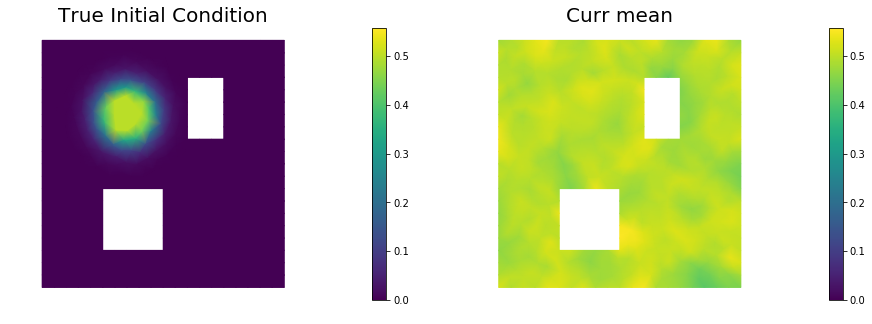

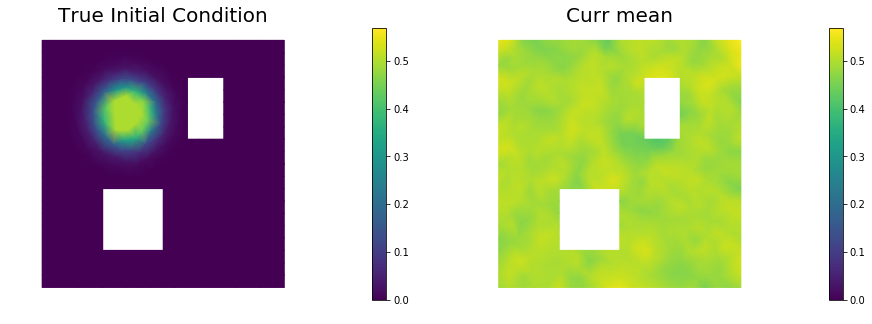

In [16]:
Q = np.copy(Qcopy)
def constructK(Q, H, noise_std_dev):
    first = np.matmul(Q, H.T)
    second= np.add(np.dot(np.dot(H, Q), H.T), noise_std_dev*noise_std_dev*np.identity(k))
    res = np.matmul(first, np.linalg.inv(second))
    return res

def constructNewQ(K, H, Q):
    return np.matmul(np.subtract(np.identity(Vh.dim()), np.matmul(K, H)), Q)

def constructNewMean(curMean, K, H):
    return curMean + np.dot(K, np.subtract(misfit.d, H.dot(curMean)))
    
Q = np.copy(Qcopy)
allEigVal = np.zeros((iters, k2))
for it in range(iters):
    c = np.random.multivariate_normal(prior.mean, Q)
    if it % 5 == 0:
        objs2 = [dl.Function(Vh, true_initial_condition), dl.Function(Vh, np_Vec_to_la_Vec(c))]
        my_titles2 = ["True Initial Condition", "Curr mean"]
        nb.multi1_plot(objs2, my_titles2)
        plt.show()
    eigVal, eigVec = np.linalg.eig(Q)
    allEigVal[it,:] = eigVal
    
    K = constructK(Q, Bops, noise_std_dev)
    Q = constructNewQ(K, Bops, Q)
    curMean = constructNewMean(curMean, K, Bops)

    


   
    

[[  1.00000000e+00   1.02140352e+01   8.11756620e+00 ...,   3.56771273e-06
    3.55745095e-06   3.56328779e-06]
 [  1.00000000e+00   1.47367388e-01   1.33563550e-01 ...,   3.35536033e-06
    3.35494059e-06   3.35823158e-06]
 [  1.00000000e+00   1.00176176e-01   9.41410818e-02 ...,   3.35530487e-06
    3.34530198e-06   3.35487604e-06]
 ..., 
 [  1.00000000e+00   5.96337875e-02   5.05516262e-02 ...,   3.35262123e-06
    3.35132654e-06   3.35605867e-06]
 [  1.00000000e+00   5.95773170e-02   5.04889145e-02 ...,   3.35122695e-06
    3.35255644e-06   3.35601165e-06]
 [  1.00000000e+00   5.95228592e-02   5.04283760e-02 ...,   3.35112608e-06
    3.35249143e-06   3.35596459e-06]]


[1.0, 0.14736738823711434, 0.13356354981747998, 0.1265959226446787, 0.094518719583180019, 0.087823203909068587, 0.083691756307063742, 0.07858273202979818, 0.075629608213074698, 0.072822285968223696, 0.064896574484885741, 0.056147065318712018, 0.055716483143797638, 0.05190531834056681, 0.049802137617132251, 0.046603677908033637, 0.044601543075051778, 0.041297859288053101, 0.039925074301722277, 0.037296463637934318, 0.035099018328021349, 0.03257759315463897, 0.029831266196301755, 0.026566592799460394, 0.024562723705347133, 0.024132171188113782, 0.023075519743704295, 0.022610389831910181, 0.021568537745104671, 0.019689237982145186, 0.018894320496955944, 0.016861105369973258, 0.015159867629412226, 0.014522443776853609, 0.013719924930697017, 0.013163193377219025, 0.01269198178178883, 0.012640893714542925, 0.011932289090698222, 0.011809031739350931, 0.010495978947460571, 0.0097910774051237076, 0.0089200543675215151, 0.0087689830127544062, 0.0085228753985411177, 0.0083192162676449313, 0.00811

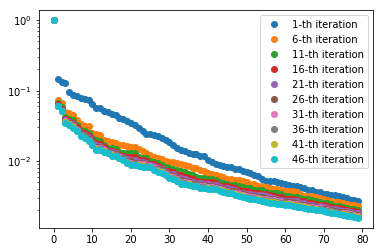

In [24]:

x = []
for i in range(k):
    x.append(i)
# np.sort(allEigVal, key = lambda x: abs(x))
for it in range(iters):
    if it % 5 == 1:
        b = sorted(allEigVal[it,:][:k], reverse = True, key = lambda x: abs(x))
        print(b)
#     plt.plot(x, allEigVal[it,:], 'o',label = str(it) + "-th iteration")
        plt.plot(x, b, 'o',label = str(it) + "-th iteration")
plt.yscale('log')
plt.legend()
plt.show()

## 9. Compute the MAP point

In [ ]:
H.misfit_only = False
        
solver = CGSolverSteihaug()
solver.set_operator(H)
solver.set_preconditioner( posterior.Hlr )
solver.parameters["print_level"] = 1
solver.parameters["rel_tolerance"] = 1e-6
solver.solve(a, -mg)
problem.solveFwd(u, [u,a,p], 1e-12)
 
total_cost, reg_cost, misfit_cost = problem.cost([u,a,p])
print("Total cost {0:5g}; Reg Cost {1:5g}; Misfit {2:5g}".format(total_cost, reg_cost, misfit_cost))
    
posterior.mean = a

plt.figure(figsize=(7.5,5))
nb.plot(dl.Function(Vh, a), mytitle="Initial Condition")
plt.show()

nb.show_solution(Vh, a, u, "Solution")

## 10. Prior and posterior pointwise variance fields

In [ ]:
compute_trace = True
if compute_trace:
    post_tr, prior_tr, corr_tr = posterior.trace(method="Estimator", tol=5e-2, min_iter=20, max_iter=2000)
    print("Posterior trace {0:5g}; Prior trace {1:5g}; Correction trace {2:5g}".format(post_tr, prior_tr, corr_tr))
post_pw_variance, pr_pw_variance, corr_pw_variance = posterior.pointwise_variance("Exact")

objs = [dl.Function(Vh, pr_pw_variance),
        dl.Function(Vh, post_pw_variance)]
mytitles = ["Prior Variance", "Posterior Variance"]
nb.multi1_plot(objs, mytitles, logscale=True)
plt.show()

## 11. Draw samples from the prior and posterior distributions

In [ ]:
nsamples = 5
noise = dl.Vector()
posterior.init_vector(noise,"noise")
noise_size = get_local_size(noise)
s_prior = dl.Function(Vh, name="sample_prior")
s_post = dl.Function(Vh, name="sample_post")

pr_max =  2.5*math.sqrt( pr_pw_variance.max() ) + prior.mean.max()
pr_min = -2.5*math.sqrt( pr_pw_variance.min() ) + prior.mean.min()
ps_max =  2.5*math.sqrt( post_pw_variance.max() ) + posterior.mean.max()
ps_min = -2.5*math.sqrt( post_pw_variance.max() ) + posterior.mean.min()

for i in range(nsamples):
    noise.set_local( np.random.randn( noise_size ) )
    posterior.sample(noise, s_prior.vector(), s_post.vector())
    plt.figure(figsize=(15,5))
    nb.plot(s_prior, subplot_loc=121,mytitle="Prior sample", vmin=pr_min, vmax=pr_max)
    nb.plot(s_post, subplot_loc=122,mytitle="Posterior sample", vmin=ps_min, vmax=ps_max)
    plt.show()

Copyright (c) 2016-2018, The University of Texas at Austin & University of California, Merced.
All Rights reserved.
See file COPYRIGHT for details.

This file is part of the hIPPYlib library. For more information and source code
availability see https://hippylib.github.io.

hIPPYlib is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License (as published by the Free Software Foundation) version 2.0 dated June 1991.